In [1]:
%load_ext autoreload
%autoreload 2

from util import *
from b_algorithm import algorithm

In [14]:
import os
import traceback

# file_name=  'STAGE1_1.json'

# problem_file = os.path.join("stage1_problems", file_name)
problem_file = os.path.join("alg_test_problems", "TEST_K50_1.json")
timelimit = 30


with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time)

alg_start_time = time.time()

exception = None

solution = None
try:
    # Run algorithm!
    solution = algorithm(K, ALL_ORDERS, ALL_RIDERS, DIST, timelimit)
except Exception as e:
    exception = f'{e}'
    print(traceback.format_exc())


alg_end_time = time.time()

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time)
 
checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

checked_solution['time'] = alg_end_time - alg_start_time
checked_solution['timelimit_exception'] = (alg_end_time - alg_start_time) > timelimit + 1 # allowing additional 1 second!
checked_solution['exception'] = exception

checked_solution['prob_name'] = prob['name']
checked_solution['prob_file'] = problem_file

checked_solution


import csv
with open("result.csv", 'w', newline = '') as f:
    writer = csv.writer(f)
    
    writer.writerow([checked_solution['avg_cost'], checked_solution['feasible'], checked_solution['time']])


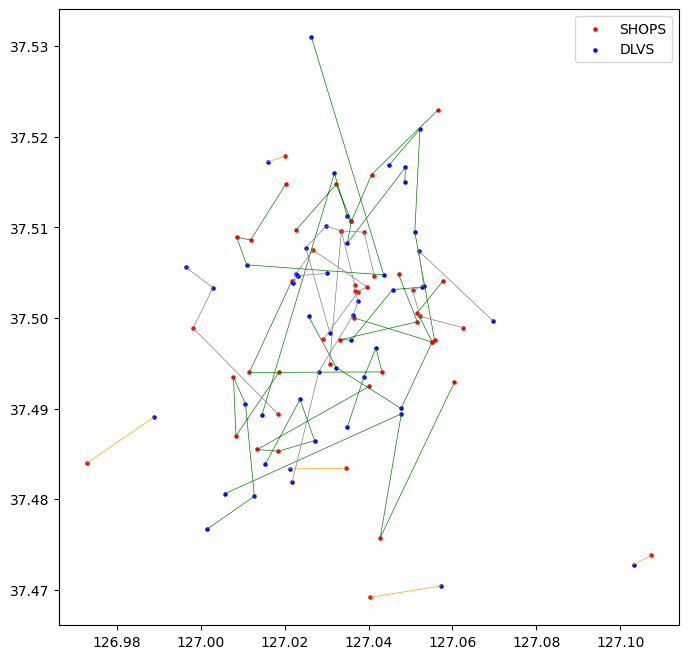

In [26]:
draw_route_solution(ALL_ORDERS, checked_solution)

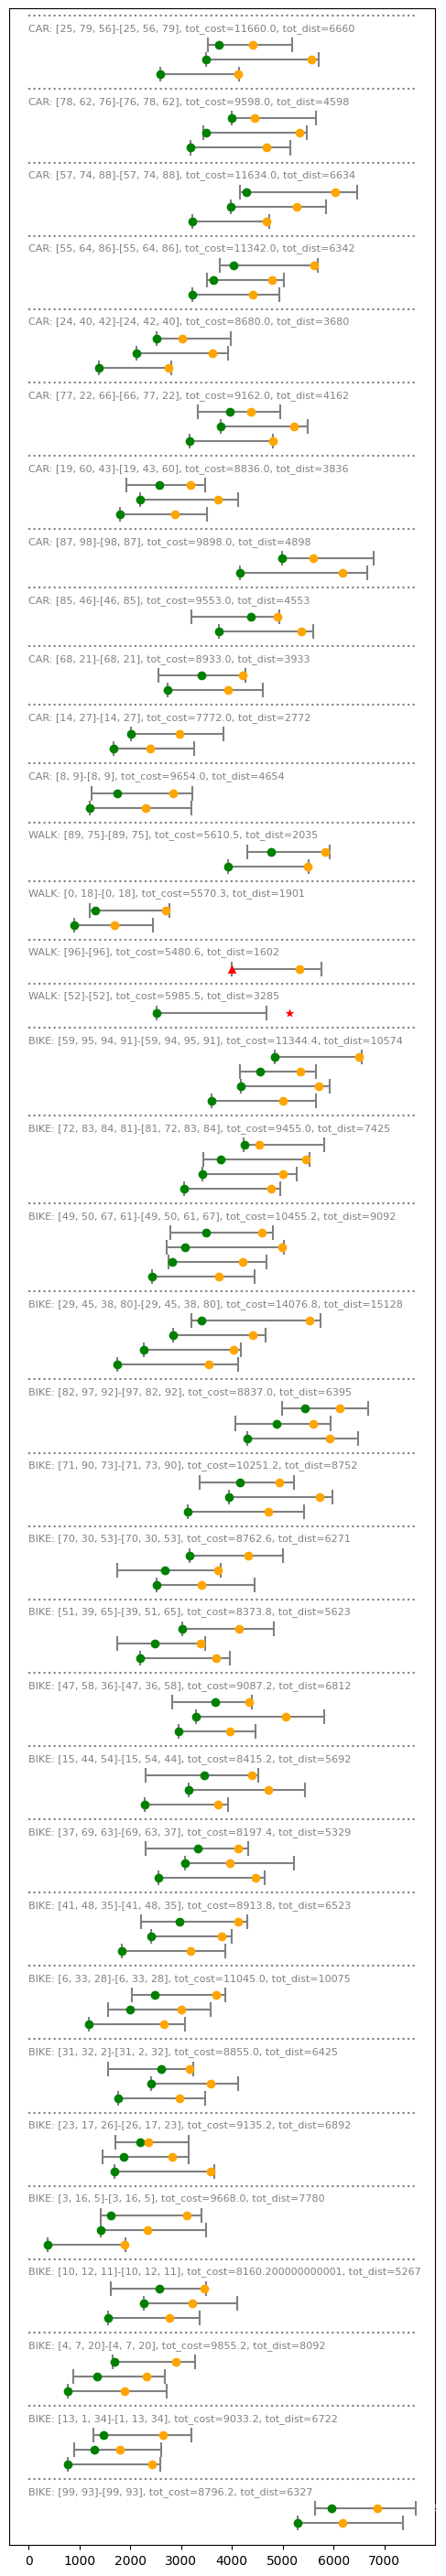

In [5]:
draw_bundle_solution(ALL_ORDERS, ALL_RIDERS, DIST, checked_solution)

In [115]:
import heapq
from util import *
from algorithm7 import find_ranks, get_allcost_cheaper_riders

car_rider = None
for r in ALL_RIDERS:
    if r.type == 'CAR':
        car_rider = r

all_bundles = []

for ord in ALL_ORDERS:
    new_bundle = Bundle(ALL_ORDERS, car_rider, [ord.id], [ord.id], ord.volume, DIST[ord.id, ord.id+K])
    all_bundles.append(new_bundle)
    car_rider.available_number -= 1

# shop. dlv 거리 행렬 구성
shop_distances = DIST[:K, :K]
dlv_distances = DIST[K:2*K, K:2*K]

for bundle1 in all_bundles:
    last_ord_time = ALL_ORDERS[bundle1.shop_seq[-1]].order_time
    first_deadline = ALL_ORDERS[bundle1.dlv_seq[0]].deadline

    avail_ord = [order.id for order in ALL_ORDERS if (order.order_time <= first_deadline) & (order.deadline >= last_ord_time) ]
    
    combine_dist = None
    for shop_seq in bundle1.shop_seq:
        if combine_dist is None:
            combine_dist = np.array(shop_distances[shop_seq])
        else:
            combine_dist += np.array(shop_distances[shop_seq])
    for dlv_seq in bundle1.dlv_seq:
        combine_dist += np.array(dlv_distances[dlv_seq])
    

    # 가게와 배달지점 사용해 순위 매김
    combine_rank = find_ranks(combine_dist)

    # 결합 개수
    c=6
    count = 0
    max_count = 20
    while True:
        if count > max_count:
            break

        # 가장 순위가 높은 c개의 요소와 인덱스를 튜플로 추출
        rank_c = heapq.nsmallest(c, enumerate(combine_rank), key=lambda x: x[1])

        # 인덱스만 추출
        rank_c_indices = [index for index, value in rank_c if value != 0]

        for selected_index in rank_c_indices:
        
            if selected_index in avail_ord:
                break
            else:
                c += 1
            
            if selected_index in bundle1.shop_seq:
                c += 1
            else:
                break

    selected_order = ALL_ORDERS[selected_index]

    # 새 번들
    bundle2 = Bundle(ALL_ORDERS, car_rider, [selected_order.id], [selected_order.id], selected_order.volume,
                        DIST[selected_order.id, selected_order.id+K])


    if selected_order.id not in bundle1.shop_seq:
        new_bundle = try_merging_bundles(K, DIST, ALL_ORDERS, bundle1, bundle2)
    else:
        new_bundle = None

    if new_bundle is None:
        break

    all_bundles.append(new_bundle)

    new_rider = get_allcost_cheaper_riders(ALL_RIDERS, new_bundle, new_bundle.rider)
    if new_rider is not None:
        old_rider = new_bundle.rider
        if try_bundle_rider_changing(ALL_ORDERS, DIST, new_bundle, new_rider):
            old_rider.available_number += 1
            new_rider.available_number -= 1